In [1]:
import itertools
import os
import shutil
from functools import partial
from time import time

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from estimagic.batch_evaluators import joblib_batch_evaluator
from sid import get_colors, get_msm_func, get_simulate_func
from sid.msm import get_diag_weighting_matrix

from src.calculate_moments import (
    smoothed_outcome_per_hundred_thousand_rki,
    smoothed_outcome_per_hundred_thousand_sim,
)
from src.config import BLD, SRC
from src.create_initial_states.create_initial_conditions import (  # noqa
    create_initial_conditions,
)
from src.manfred.shared import hash_array
from src.plotting.msm_plots import plot_estimation_moment
from src.policies.combine_policies_over_periods import (
    get_enacted_policies_of_2021,
    get_october_to_christmas_policies,
)
from src.policies.policy_tools import combine_dictionaries
from src.simulation.main_specification import (
    SIMULATION_DEPENDENCIES,
    load_simulation_inputs,
)

SAVED_COLUMNS = {
    "initial_states": ["age_group_rki"],
    "disease_states": ["newly_infected", "newly_deceased"],
    "time": ["date"],
    "other": [
        "new_known_case",
        "channel_infected_by_contact",
        "virus_strain",
        "state",
    ],
}


import warnings

warnings.simplefilter("ignore")
%load_ext snakeviz

# Load the simulation inputs

In [2]:
simulation_dependencies = SIMULATION_DEPENDENCIES.copy()
simulation_dependencies["initial_states"] = (
    BLD / "data" / "debug_initial_states.parquet"
)


start_date = pd.Timestamp("2020-09-15")
init_start = start_date - pd.Timedelta(31, unit="D")
end_date = pd.Timestamp("2020-11-03")
init_end = start_date - pd.Timedelta(1, unit="D")

virus_shares, kwargs = load_simulation_inputs(
    simulation_dependencies,
    init_start,
    end_date,
)
# we don't want to parse the "old" params
kwargs.pop("params")


full_simulate_inputs = {
    "duration": {"start": start_date, "end": end_date},
    "initial_conditions": create_initial_conditions(
        start=init_start,
        end=init_end,
        seed=344490,
        reporting_delay=5,
        virus_shares=virus_shares,
        synthetic_data_path=BLD / "data" / "debug_initial_states.parquet",
    ),
    "contact_policies": get_october_to_christmas_policies(
        contact_models=kwargs["contact_models"],
    ),
    "saved_columns": SAVED_COLUMNS,
    **kwargs,
}

In [3]:
len(full_simulate_inputs["initial_conditions"]["initial_infections"])

201951

# Build the criterion

In [4]:
def _simulate_wrapper(params, simulate):
    return simulate(params)["time_series"]


def build_and_evaluate_msm_func(params, seed, prefix, simulate_kwargs):
    params_hash = hash_array(params["value"].to_numpy())
    path = SRC / "exploration" / f"{prefix}_{params_hash}_{os.getpid()}"

    simulate = get_simulate_func(
        **simulate_kwargs,
        params=params,
        path=path / "fall_part",
        seed=seed,
    )

    calc_moments = {
        "infections_by_age_group": partial(
            smoothed_outcome_per_hundred_thousand_sim,
            outcome="new_known_case",
            groupby="age_group_rki",
            window=7,
            min_periods=1,
            take_logs=True,
        ),
        "aggregated_deaths": partial(
            smoothed_outcome_per_hundred_thousand_sim,
            outcome="newly_deceased",
            window=7,
            min_periods=1,
            take_logs=True,
        ),
        "infections_by_state": partial(
            smoothed_outcome_per_hundred_thousand_sim,
            outcome="new_known_case",
            groupby="state",
            window=7,
            min_periods=1,
            take_logs=True,
        ),
        "aggregated_infections": partial(
            smoothed_outcome_per_hundred_thousand_sim,
            outcome="new_known_case",
            window=7,
            min_periods=1,
            take_logs=False,
        ),
    }

    # empirical moments
    rki_data = pd.read_pickle(BLD / "data" / "processed_time_series" / "rki.pkl")
    rki_data = rki_data.loc[
        simulate_kwargs["duration"]["start"] : simulate_kwargs["duration"]["end"]
    ]
    age_group_info = pd.read_pickle(
        BLD / "data" / "population_structure" / "age_groups_rki.pkl"
    )

    state_info = pd.read_parquet(
        BLD / "data" / "population_structure" / "federal_states.parquet"
    )
    state_sizes = state_info.set_index("name")["population"]
    state_weights = state_sizes / state_sizes.sum()
    state_weights

    empirical_moments = {
        "infections_by_age_group": smoothed_outcome_per_hundred_thousand_rki(
            df=rki_data,
            outcome="newly_infected",
            groupby="age_group_rki",
            window=7,
            min_periods=1,
            group_sizes=age_group_info["n"],
            take_logs=True,
        ),
        "aggregated_deaths": smoothed_outcome_per_hundred_thousand_rki(
            df=rki_data,
            outcome="newly_deceased",
            window=7,
            min_periods=1,
            take_logs=True,
        ),
        "infections_by_state": smoothed_outcome_per_hundred_thousand_rki(
            df=rki_data,
            outcome="newly_infected",
            groupby="state",
            window=7,
            min_periods=1,
            group_sizes=state_sizes,
            take_logs=True,
        ),
        "aggregated_infections": smoothed_outcome_per_hundred_thousand_rki(
            df=rki_data,
            outcome="newly_infected",
            window=7,
            min_periods=1,
            take_logs=False,
        ),
    }

    # weighting matrix
    age_weights = age_group_info["weight"].to_dict()
    temp = empirical_moments["infections_by_age_group"].to_frame().copy(deep=True)
    temp["age_group"] = temp.index.get_level_values(1)
    temp["weights"] = temp["age_group"].replace(age_weights)
    age_weights = temp["weights"]

    state_weights = state_weights.to_dict()
    temp = empirical_moments["infections_by_state"].to_frame().copy(deep=True)
    temp["state"] = temp.index.get_level_values(1)
    temp["weights"] = temp["state"].replace(state_weights)
    state_weights = temp["weights"]

    weights = {
        "infections_by_age_group": age_weights,
        "aggregated_deaths": 0.1,
        "infections_by_state": state_weights,
        # extremely low weight because not in logs
        "aggregated_infections": 1e-8,
    }

    weight_mat = get_diag_weighting_matrix(
        empirical_moments=empirical_moments,
        weights=weights,
    )

    msm_func = get_msm_func(
        simulate=partial(_simulate_wrapper, simulate=simulate),
        calc_moments=calc_moments,
        empirical_moments=empirical_moments,
        replace_nans=lambda x: x * 1,
        weighting_matrix=weight_mat,
    )

    res = msm_func(params)
    shutil.rmtree(path)
    return res


def _get_period_length(inputs):
    return inputs["duration"]["end"] - inputs["duration"]["start"]


pmsm = partial(
    build_and_evaluate_msm_func,
    prefix="gridsearch",
    simulate_kwargs=full_simulate_inputs,
)


def reshape_flat_list(flat_list, n_rows, n_cols):
    assert n_rows * n_cols == len(flat_list)
    reshaped = []
    entries = iter(flat_list)
    for r in range(n_rows):
        row = []
        for c in range(n_cols):
            row.append(next(entries))
        reshaped.append(row)
    return reshaped


def visualize_msm_evaluations(msm_evaluations, key="infections_by_age_group", period=0):
    """Visualize a list of outputs of the msm criterion function.

    The plot contains the mean moments over all list elements as well
    as the individual lines.

    All moments are assumed to be disaggregated by age groups.

    Args:
        msm_evaluations (list): List of outputs of the msm criterion function.
        key (str): Used to select an element from the dictionaries of empirical
            and simulated moments.

    """
    if isinstance(msm_evaluations, dict):
        msm_evaluations = [msm_evaluations]

    colors = get_colors(palette="categorical", number=2)

    fig, axes = plt.subplots(nrows=7, figsize=(8, 16), sharex=False)

    if isinstance(msm_evaluations[0]["empirical_moments"], list):
        is_list_result = True
    else:
        is_list_result = False

    if is_list_result:
        emp_mom_sr = msm_evaluations[0]["empirical_moments"][period][key]
    else:
        emp_mom_sr = msm_evaluations[0]["empirical_moments"][key]

    emp_mom = _unstack_moment_series_with_flattened_index(emp_mom_sr)

    if is_list_result:
        sim_moms = [res["simulated_moments"][period][key] for res in msm_evaluations]
    else:
        sim_moms = [res["simulated_moments"][key] for res in msm_evaluations]

    mean_sim_mom = _unstack_moment_series_with_flattened_index(
        pd.concat(sim_moms, axis=1).mean(axis=1)
    )
    emp_mom = emp_mom.loc[mean_sim_mom.index]

    age_groups = ["0-4", "5-14", "15-34", "35-59", "60-79", "80-100"]

    for age_group, ax in zip(age_groups, axes[1:]):
        for mom in sim_moms:
            mom_df = _unstack_moment_series_with_flattened_index(mom)
            sns.lineplot(
                x=mom_df.index,
                y=mom_df[age_group],
                color=colors[0],
                alpha=0.4,
                linewidth=0.8,
                ax=ax,
            )
        sns.lineplot(
            x=mean_sim_mom.index,
            y=mean_sim_mom[age_group],
            label="simulated",
            color=colors[0],
            ax=ax,
            linewidth=2.5,
        )

        sns.lineplot(
            x=emp_mom.index,
            y=emp_mom[age_group],
            label="empirical",
            color=colors[1],
            ax=ax,
            linewidth=2.5,
        )
        ax.set_title(f"Goodness of Fit: {age_group}")
        ax.set_ylabel("Infections per 100 000")

    # add overall fitness plot
    ax = axes[0]

    age_group_info = pd.read_pickle(
        BLD / "data" / "population_structure" / "age_groups_rki.pkl"
    )
    age_weights = age_group_info["weight"]

    aggregated_emp_mom = (emp_mom * age_weights).sum(axis=1)

    mean_agg_sim_mom = (
        _unstack_moment_series_with_flattened_index(
            pd.concat(sim_moms, axis=1).mean(axis=1)
        )
        * age_weights
    ).sum(axis=1)

    agg_sim_moms = [
        (_unstack_moment_series_with_flattened_index(mom) * age_weights).sum(axis=1)
        for mom in sim_moms
    ]

    for mom in agg_sim_moms:

        sns.lineplot(
            x=mom.index,
            y=mom,
            color=colors[0],
            alpha=0.4,
            linewidth=0.8,
            ax=ax,
        )

    sns.lineplot(
        x=aggregated_emp_mom.index,
        y=aggregated_emp_mom,
        label="empirical",
        color=colors[1],
        ax=ax,
        linewidth=2.5,
    )

    sns.lineplot(
        x=mean_agg_sim_mom.index,
        y=mean_agg_sim_mom,
        label="simulated",
        color=colors[0],
        ax=ax,
        linewidth=2.5,
    )
    ax.set_title("Overall Goodness of Fit")
    ax.set_ylabel("Infections per 100 000")

    for ax in axes:
        ax.xaxis.set_major_locator(plt.MaxNLocator(8))

    fig.tight_layout()
    return fig, ax


def _unstack_moment_series_with_flattened_index(sr):
    """Unstack a moment series with flattene index into a DataFrame.

    The columns of the DataFrame are the age groups. The index of
    the DataFrame is the date.

    """
    sr = sr.copy()
    sr.name = "value"
    df = sr.to_frame()
    df["date"] = list(map(lambda x: x.split("'", 2)[1], df.index))
    df["date"] = pd.to_datetime(df["date"])
    df["group"] = list(map(lambda x: x.rsplit(",", 1)[1].strip("') "), df.index))
    df.set_index(["date", "group"], inplace=True)
    return df["value"].unstack()

# Params

In [5]:
params = pd.read_pickle(BLD / "params.pkl")
params.loc[("virus_strain", "base_strain", "factor")] = 1.0
params.loc[("virus_strain", "b117", "factor")] = 1.67

params.loc["infection_prob"]

# using loc and index is necessary for later assignments to work
hh_probs = params.loc[[("infection_prob", "households", "households")]].index
school_probs = params.loc[
    [
        ("infection_prob", "educ_school_0", "educ_school_0"),
        ("infection_prob", "educ_school_1", "educ_school_1"),
        ("infection_prob", "educ_school_2", "educ_school_2"),
    ]
].index

young_educ_probs = params.loc[
    [
        ("infection_prob", "educ_preschool_0", "educ_preschool_0"),
        ("infection_prob", "educ_nursery_0", "educ_nursery_0"),
    ]
].index

work_probs = params.loc[
    [
        ("infection_prob", "work_non_recurrent", "work_non_recurrent"),
        ("infection_prob", "work_recurrent_daily", "work_recurrent_daily"),
        ("infection_prob", "work_recurrent_weekly_0", "work_recurrent_weekly_0"),
        ("infection_prob", "work_recurrent_weekly_1", "work_recurrent_weekly_1"),
        ("infection_prob", "work_recurrent_weekly_2", "work_recurrent_weekly_2"),
        ("infection_prob", "work_recurrent_weekly_3", "work_recurrent_weekly_3"),
        ("infection_prob", "work_recurrent_weekly_4", "work_recurrent_weekly_4"),
        ("infection_prob", "work_recurrent_weekly_5", "work_recurrent_weekly_5"),
        ("infection_prob", "work_recurrent_weekly_6", "work_recurrent_weekly_6"),
        ("infection_prob", "work_recurrent_weekly_7", "work_recurrent_weekly_7"),
        ("infection_prob", "work_recurrent_weekly_8", "work_recurrent_weekly_8"),
        ("infection_prob", "work_recurrent_weekly_9", "work_recurrent_weekly_9"),
        ("infection_prob", "work_recurrent_weekly_10", "work_recurrent_weekly_10"),
        ("infection_prob", "work_recurrent_weekly_11", "work_recurrent_weekly_11"),
        ("infection_prob", "work_recurrent_weekly_12", "work_recurrent_weekly_12"),
        ("infection_prob", "work_recurrent_weekly_13", "work_recurrent_weekly_13"),
    ]
].index

other_probs = params.loc[
    [
        ("infection_prob", "other_non_recurrent", "other_non_recurrent"),
        ("infection_prob", "other_recurrent_daily", "other_recurrent_daily"),
        ("infection_prob", "other_recurrent_weekly_0", "other_recurrent_weekly_0"),
        ("infection_prob", "other_recurrent_weekly_1", "other_recurrent_weekly_1"),
        ("infection_prob", "other_recurrent_weekly_2", "other_recurrent_weekly_2"),
        ("infection_prob", "other_recurrent_weekly_3", "other_recurrent_weekly_3"),
    ]
].index

prob_types = [hh_probs, school_probs, young_educ_probs, work_probs, other_probs]

free_probs = [probs[0] for probs in prob_types]


params.loc[other_probs, "value"] = 0.16  # Done
params.loc[young_educ_probs, "value"] = 0.005
params.loc[school_probs, "value"] = 0.01
params.loc[work_probs, "value"] = 0.15
params.loc[hh_probs] = 0.095
params.loc[free_probs]

value
category       subcategory         name                      
infection_prob households          households           0.095
               educ_school_0       educ_school_0        0.010
               educ_preschool_0    educ_preschool_0     0.005
               work_non_recurrent  work_non_recurrent   0.150
               other_non_recurrent other_non_recurrent  0.160

In [6]:
locs = work_probs
lb = 0.16
ub = 0.16
n_points = 1

seeds = [
    1_000_000,
    2_000_000,
    3_000_000,
]

n_cores = 3

grid = np.linspace(lb, ub, n_points)
arguments = []
for point, seed in itertools.product(grid, seeds):
    p = params.copy(deep=True)
    p.loc[locs, "value"] = point
    arguments.append({"params": p, "seed": seed})


results = joblib_batch_evaluator(
    func=pmsm,
    arguments=arguments,
    n_cores=n_cores,
    unpack_symbol="**",
)
reshaped_results = reshape_flat_list(results, n_points, len(seeds))

In [7]:
avg_values = []
for row in reshaped_results:
    values = [res["value"] for res in row]
    avg_values.append(np.mean(values))

best_grid_index = np.argmin(avg_values)

<AxesSubplot:>

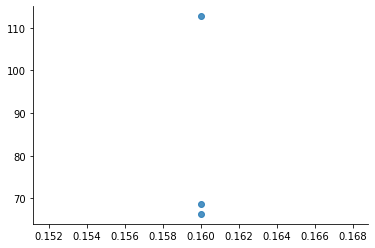

In [8]:
sns.regplot(
    np.repeat(grid, len(seeds)),
    [res["value"] for res in results],
    order=3,
)

In [9]:
grid

array([0.16])

In [10]:
ix = best_grid_index
grid[ix]

0.16

In [11]:
avg_values[ix]

82.60083782608798

In [12]:
best_grid_index

0

In [13]:
results[0]["simulated_moments"].keys()

dict_keys(['infections_by_age_group', 'aggregated_deaths', 'infections_by_state', 'aggregated_infections'])

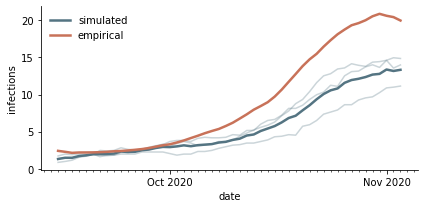

In [14]:
plot_estimation_moment(results, "aggregated_infections")